##### Copyright 2018 The TensorFlow Authors.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import openpyxl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print(tf.__version__)

2.10.0


In [2]:
df = pd.read_excel('./datasets/combined.xlsx', index_col=0)
del df['Highest 30 min Rainfall (mm)']
del df['Highest 60 min Rainfall (mm)']

In [3]:
dataset = df.copy()
dataset.tail()

,Dwelling Type,Year,Month,Region,Towns,Avg kWh,Daily Rainfall Total (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
60563,Public Housing,2021,6,West Region,Choa Chu Kang,470.8,9.8,9.4,28.1,32.7,24.5,8.6,31.9
60564,Public Housing,2021,6,West Region,Clementi,360.1,7.5,6.7,28.2,32.1,25.2,4.9,26.5
60565,Public Housing,2021,6,West Region,Jurong East,434.2,8.5,7.9,28.2,32.4,24.9,6.7,29.2
60566,Public Housing,2021,6,West Region,Jurong West,435.8,8.5,7.9,28.2,32.4,24.9,6.7,29.2
60567,Public Housing,2021,6,West Region,West Region,426.5,8.5,7.9,28.2,32.4,24.9,6.7,29.2


### Clean the data

The dataset contains a few unknown values:

In [4]:
dataset.isna().sum()

Dwelling Type                    0
Year                             0
Month                            0
Region                           0
Towns                            0
Avg kWh                          0
Daily Rainfall Total (mm)        0
Highest 120 min Rainfall (mm)    0
Mean Temperature (°C)            0
Maximum Temperature (°C)         0
Minimum Temperature (°C)         0
Mean Wind Speed (km/h)           0
Max Wind Speed (km/h)            0
dtype: int64

In [5]:
#one hot encoding
dataset = pd.get_dummies(dataset, columns=['Dwelling Type', 'Month', 'Towns', 'Region'], prefix='', prefix_sep='')
first_column = dataset.pop('Avg kWh')
dataset.insert(0, 'Avg kWh', first_column)
dataset.tail()


,Avg kWh,Year,Daily Rainfall Total (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),1-room / 2-room,...,Tanglin,Toa Payoh,West Region,Woodlands,Yishun,Central Region,East Region,North East Region,North Region,West Region
60563,470.8,2021,9.8,9.4,28.1,32.7,24.5,8.6,31.9,0,...,0,0,0,0,0,0,0,0,0,1
60564,360.1,2021,7.5,6.7,28.2,32.1,25.2,4.9,26.5,0,...,0,0,0,0,0,0,0,0,0,1
60565,434.2,2021,8.5,7.9,28.2,32.4,24.9,6.7,29.2,0,...,0,0,0,0,0,0,0,0,0,1
60566,435.8,2021,8.5,7.9,28.2,32.4,24.9,6.7,29.2,0,...,0,0,0,0,0,0,0,0,0,1
60567,426.5,2021,8.5,7.9,28.2,32.4,24.9,6.7,29.2,0,...,0,0,1,0,0,0,0,0,0,1


### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Let's also check the overall statistics. Note how each feature covers a very different range:

In [7]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Avg kWh,48454.0,566.847244,430.268789,0.0,321.2,441.6,692.9,7161.319423
Year,48454.0,2012.770917,4.755051,2005.0,2009.0,2013.0,2017.0,2021.000000
Daily Rainfall Total (mm),48454.0,6.836511,3.669284,0.0,4.3,6.4,8.9,64.600000
Highest 120 min Rainfall (mm),48454.0,5.082978,1.796803,0.0,4.2,5.0,5.8,24.200000
Mean Temperature (°C),48454.0,27.590946,0.708405,24.8,27.2,27.6,28.1,30.000000
...,...,...,...,...,...,...,...,...
Central Region,48454.0,0.410802,0.491984,0.0,0.0,0.0,1.0,1.000000
East Region,48454.0,0.125026,0.330752,0.0,0.0,0.0,0.0,1.000000
North East Region,48454.0,0.161720,0.368198,0.0,0.0,0.0,0.0,1.000000
North Region,48454.0,0.119557,0.324446,0.0,0.0,0.0,0.0,1.000000


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [8]:
X_train = train_dataset.copy()
X_test = test_dataset.copy()

y_train = X_train.pop('Avg kWh')
y_test = X_test.pop('Avg kWh')
#train_labels

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [9]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Avg kWh,566.847244,430.268789
Year,2012.770917,4.755051
Daily Rainfall Total (mm),6.836511,3.669284
Highest 120 min Rainfall (mm),5.082978,1.796803
Mean Temperature (°C),27.590946,0.708405
...,...,...
Central Region,0.410802,0.491984
East Region,0.125026,0.330752
North East Region,0.161720,0.368198
North Region,0.119557,0.324446


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [10]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [11]:
normalizer.adapt(np.array(X_train))

Calculate the mean and variance, and store them in the layer:

In [12]:
print(normalizer.mean.numpy())

[[2.01277039e+03 6.83651209e+00 5.08296824e+00 2.75909252e+01
  3.16137466e+01 2.49113503e+01 7.53638649e+00 3.30950966e+01
  1.02261953e-01 1.11322068e-01 1.13881163e-01 1.13344572e-01
  1.42320335e-01 1.47562593e-01 1.52082369e-01 1.17224544e-01
  8.65150541e-02 8.46575722e-02 8.67626965e-02 8.58547091e-02
  8.57722610e-02 8.63292962e-02 8.08808580e-02 8.15000311e-02
  8.11283588e-02 8.01378936e-02 7.94155747e-02 8.10459927e-02
  2.64993496e-02 2.62517221e-02 2.58182883e-02 2.59008650e-02
  2.60040350e-02 2.44561620e-02 2.42498051e-02 2.61691641e-02
  1.43228471e-02 2.54880749e-02 2.64167842e-02 2.11953633e-02
  2.57151220e-02 2.63548978e-02 2.60246880e-02 2.34449040e-02
  2.58595999e-02 2.58595776e-02 1.02158831e-02 2.57770028e-02
  8.44100211e-03 9.80312657e-03 2.61691418e-02 2.56738383e-02
  2.66644675e-02 7.75993010e-03 2.61897687e-02 2.41672341e-02
  8.27588607e-03 5.07697696e-03 2.25368589e-02 2.70153172e-02
  1.00507652e-02 2.62517035e-02 9.51416884e-03 2.32591499e-02
  2.4683

When the layer is called, it returns the input data, with each feature independently normalized:

In [13]:
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[2008.     7.2    5.    27.6   31.6   24.4    8.9   32.5    0.     0.
     0.     1.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     1.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     1.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     1.     0.     0. ]]

Normalized: [[-1.    0.1  -0.05  0.01 -0.02 -0.68  0.62 -0.16 -0.34 -0.35 -0.36  2.8
  -0.41 -0.42 -0.42 -0.36 -0.31 -0.3  -0.31 -0.31 -0.31 -0.31 -0.3  -0.3
   3.37 -0.3  -0.29 -0.3  -0.16 -0.16 -0.16 -0.16 -0.16 -0.16 -0.16 -0.16
  -0.12 -0.16 -0.16 -0.15 -0.16 -0.16 -0.16 -0.15 -0.16 -0.16 -0.1  -0.16
  -0.09 -0.1  -0.16 -0.16 -0.17 -0.09 -0.16 -0.16 -0.09 -0.07 -0.15 -0.17
  -0.1  -0.16 -0.1  -0.15  6.29 -

In [14]:
eval_results = {}
def perform_eval(model, model_name):
    #Mean squared error 
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    #Train
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    #Test
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

    #R Squared Score
    #Train
    r2train = r2_score(y_train, y_train_pred)
    adjr2_train = 1 - (1-r2train) * (len(y_test)-1)/(len(y_test)-X_train.shape[1]-1)
    #Test
    r2test = r2_score(y_test, y_test_pred)
    adjr2_test = 1 - (1-r2test) * (len(y_test)-1)/(len(y_test)-X_train.shape[1]-1)
    
    eval_results[model_name] = {
        "MSE (Train)" : mse_train,
        "MSE (Test)" : mse_test,
        "RMSE (Train)" : rmse_train,
        "RMSE (Test)" : rmse_test,
        "R2 (Train)" : r2train,
        "R2 (Test)" : r2test,
        "Adj R2 (Train)" : adjr2_train,
        "Adj R2 (Test)" : adjr2_test
    }
    
    return eval_results[model_name]

In [15]:
def build_and_compile_model(norm, activation_function):
  if activation_function != "leaky_relu":
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation=activation_function),
        layers.Dense(64, activation=activation_function),
        layers.Dense(1)
    ])
  else:
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
        layers.Dense(1)
    ])

  model.compile(loss='huber_loss',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model
test_results = {}

In [16]:
best_model = ""
def get_best_model(model, best_model):
    if best_model == "":
        best_model = model

    #test adj r2
    y_test_pred = model.predict(X_test)
    best_adjr2_test = 1 - (1-r2_score(y_test, best_model.predict(X_test))) * (len(y_test)-1)/(len(y_test)-X_train.shape[1]-1)
    model_adjr2_test = 1 - (1-r2_score(y_test, model.predict(X_test))) * (len(y_test)-1)/(len(y_test)-X_train.shape[1]-1)

    if model_adjr2_test > best_adjr2_test:
        best_model = model

    return best_model

In [17]:
def compare_results(desired_model):
    metric_data = []
    col_names = ["Models"]
    col_done = False

    for model in eval_results:
        eval_list = []
        #Append Model names
        if (desired_model.lower() in str(model).lower()) or (desired_model.lower() == "all"):
            eval_list.append(model)
            for metric in eval_results[model]:
                if not col_done:
                    col_names.append(metric)
                eval_list.append(eval_results[model][metric])
            col_done = True
            metric_data.append(eval_list)
        
    df = pd.DataFrame(metric_data, columns=col_names)
    df = df.sort_values(by=['Adj R2 (Test)'], ascending=False)
    df = df.style.set_table_attributes("style='display:inline'").set_caption(f'{str(desired_model).capitalize()} Models (Sort by Adj R2 (Test))')
    
    return df

In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Avg kWh]')
  plt.legend()
  plt.grid(True)

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `Avg kWh` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the different activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below.

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 80)               161       
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                5184      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,570
Trainable params: 9,409
Non-trainable params: 161
_________________________________________________________________


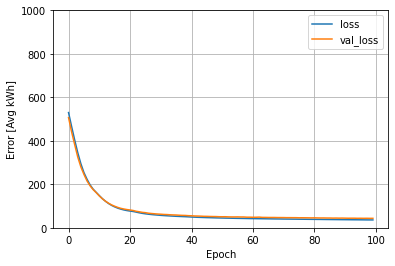

In [19]:
sigmoid_dnn_model = build_and_compile_model(normalizer, "sigmoid")
sigmoid_dnn_model.summary()

history = sigmoid_dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

In [37]:
best_model = get_best_model(sigmoid_dnn_model, best_model)
res_val = perform_eval(sigmoid_dnn_model, "DNN (Sigmoid)")
for key in res_val:image.png
    print(f"{key}: {res_val[key]}")

filename = 'DNN (Sigmoid)'
save_location = os.path.join(".","trained_models", filename)
sigmoid_dnn_model.save(save_location)

379/379 [==============================] - 1s 2ms/step
MSE (Train): 22748.244634368228
MSE (Test): 24694.764458997968
RMSE (Train): 150.82521219732538
RMSE (Test): 157.14567909744756
R2 (Train): 0.8771211426280316
R2 (Test): 0.8634496500794434
Adj R2 (Train): 0.8763041968464512
Adj R2 (Test): 0.8625418109708549
INFO:tensorflow:Assets written to: .\trained_models\DNN (Sigmoid)\assets


INFO:tensorflow:Assets written to: .\trained_models\DNN (Sigmoid)\assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 80)               161       
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                5184      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,570
Trainable params: 9,409
Non-trainable params: 161
_________________________________________________________________


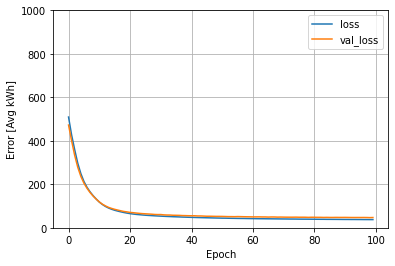

In [21]:
tanh_dnn_model = build_and_compile_model(normalizer, "tanh")
tanh_dnn_model.summary()

history = tanh_dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

In [38]:
best_model = get_best_model(tanh_dnn_model, best_model)
res_val = perform_eval(tanh_dnn_model, "DNN (Tanh)")
for key in res_val:
    print(f"{key}: {res_val[key]}")

filename = 'DNN (Tanh)'
save_location = os.path.join(".","trained_models", filename)
tanh_dnn_model.save(save_location)

379/379 [==============================] - 1s 1ms/step
MSE (Train): 31163.247589356637
MSE (Test): 33717.201326146336
RMSE (Train): 176.5311518949464
RMSE (Test): 183.62244232703785
R2 (Train): 0.8316659453365228
R2 (Test): 0.8135598479964625
Adj R2 (Train): 0.8305467959662014
Adj R2 (Test): 0.8123203223453129
INFO:tensorflow:Assets written to: .\trained_models\DNN (Tanh)\assets


INFO:tensorflow:Assets written to: .\trained_models\DNN (Tanh)\assets


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 80)               161       
 n)                                                              
                                                                 
 dense_6 (Dense)             (None, 64)                5184      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,570
Trainable params: 9,409
Non-trainable params: 161
_________________________________________________________________


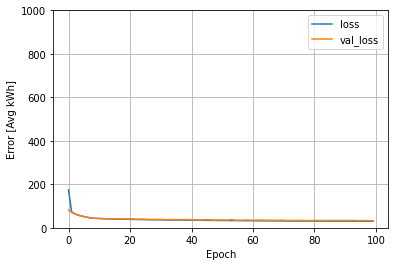

In [23]:
swish_dnn_model = build_and_compile_model(normalizer, "swish")
swish_dnn_model.summary()

history = swish_dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

In [39]:
best_model = get_best_model(swish_dnn_model, best_model)
res_val = perform_eval(swish_dnn_model, "DNN (Swish)")
for key in res_val:
    print(f"{key}: {res_val[key]}")

filename = 'DNN (Swish)'
save_location = os.path.join(".","trained_models", filename)
swish_dnn_model.save(save_location)

379/379 [==============================] - 1s 1ms/step
MSE (Train): 5902.273171272561
MSE (Test): 6225.599024819964
RMSE (Train): 76.82625313831569
RMSE (Test): 78.90246526452746
R2 (Train): 0.968117778103746
R2 (Test): 0.9655753863651657
Adj R2 (Train): 0.9679058128621852
Adj R2 (Test): 0.9653465183280356
INFO:tensorflow:Assets written to: .\trained_models\DNN (Swish)\assets


INFO:tensorflow:Assets written to: .\trained_models\DNN (Swish)\assets


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 80)               161       
 n)                                                              
                                                                 
 dense_9 (Dense)             (None, 64)                5184      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,570
Trainable params: 9,409
Non-trainable params: 161
_________________________________________________________________


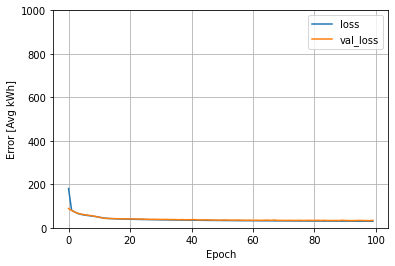

In [25]:
elu_dnn_model = build_and_compile_model(normalizer, "elu")
elu_dnn_model.summary()

history = elu_dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

In [40]:
best_model = get_best_model(elu_dnn_model, best_model)
res_val = perform_eval(elu_dnn_model, "DNN (eLU)")
for key in res_val:
    print(f"{key}: {res_val[key]}")

filename = 'DNN (eLU)'
save_location = os.path.join(".","trained_models", filename)
elu_dnn_model.save(save_location)

379/379 [==============================] - 1s 1ms/step
MSE (Train): 5316.102072135901
MSE (Test): 5795.132744967051
RMSE (Train): 72.9116045094051
RMSE (Test): 76.12576925698059
R2 (Train): 0.9712840898805045
R2 (Test): 0.967955660987364
Adj R2 (Train): 0.97109317549427
Adj R2 (Test): 0.9677426179290235
INFO:tensorflow:Assets written to: .\trained_models\DNN (eLU)\assets


INFO:tensorflow:Assets written to: .\trained_models\DNN (eLU)\assets


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 80)               161       
 n)                                                              
                                                                 
 dense_12 (Dense)            (None, 64)                5184      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,570
Trainable params: 9,409
Non-trainable params: 161
_________________________________________________________________


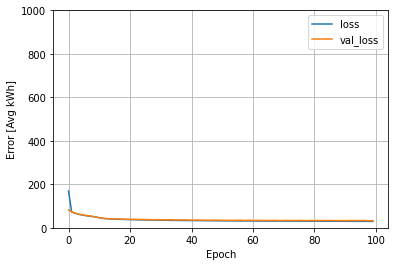

In [27]:
relu_dnn_model = build_and_compile_model(normalizer, "relu")
relu_dnn_model.summary()

history = relu_dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

In [41]:
best_model = get_best_model(relu_dnn_model, best_model)
res_val = perform_eval(relu_dnn_model, "DNN (ReLU)")
for key in res_val:
    print(f"{key}: {res_val[key]}")

filename = 'DNN (ReLU)'
save_location = os.path.join(".","trained_models", filename)
relu_dnn_model.save(save_location)

379/379 [==============================] - 1s 1ms/step
MSE (Train): 5398.465903593392
MSE (Test): 5882.6361593077
RMSE (Train): 73.47425333811424
RMSE (Test): 76.69834521883571
R2 (Train): 0.9708391863874682
R2 (Test): 0.9674718085551086
Adj R2 (Train): 0.9706453141121418
Adj R2 (Test): 0.967255548660187
INFO:tensorflow:Assets written to: .\trained_models\DNN (ReLU)\assets


INFO:tensorflow:Assets written to: .\trained_models\DNN (ReLU)\assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 80)               161       
 n)                                                              
                                                                 
 dense_15 (Dense)            (None, 64)                5184      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,570
Trainable params: 9,409
Non-trainable params: 161
_________________________________________________________________


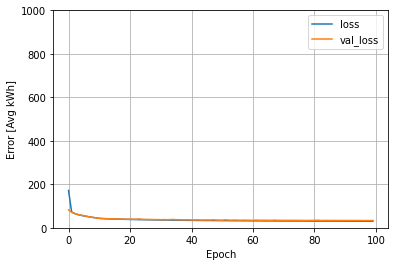

In [29]:
gelu_dnn_model = build_and_compile_model(normalizer, "gelu")
gelu_dnn_model.summary()

history = gelu_dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

In [42]:
best_model = get_best_model(gelu_dnn_model, best_model)
res_val = perform_eval(gelu_dnn_model, "DNN (GeLU)")
for key in res_val:
    print(f"{key}: {res_val[key]}")

filename = 'DNN (GeLU)'
save_location = os.path.join(".","trained_models", filename)
gelu_dnn_model.save(save_location)

379/379 [==============================] - 1s 2ms/step
MSE (Train): 5703.629674740745
MSE (Test): 6239.575790459738
RMSE (Train): 75.52237863534718
RMSE (Test): 78.99098550125665
R2 (Train): 0.96919078774781
R2 (Test): 0.965498101471761
Adj R2 (Train): 0.968985956285982
Adj R2 (Test): 0.965268719615012
INFO:tensorflow:Assets written to: .\trained_models\DNN (GeLU)\assets


INFO:tensorflow:Assets written to: .\trained_models\DNN (GeLU)\assets


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 80)               161       
 n)                                                              
                                                                 
 dense_18 (Dense)            (None, 64)                5184      
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,570
Trainable params: 9,409
Non-trainable params: 161
_________________________________________________________________


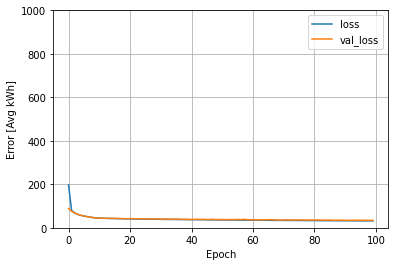

In [31]:
selu_dnn_model = build_and_compile_model(normalizer, "selu")
selu_dnn_model.summary()

history = selu_dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

In [43]:
best_model = get_best_model(selu_dnn_model, best_model)
res_val = perform_eval(selu_dnn_model, "DNN (SeLU)")
for key in res_val:
    print(f"{key}: {res_val[key]}")

filename = 'DNN (SeLU)'
save_location = os.path.join(".","trained_models", filename)
selu_dnn_model.save(save_location)

379/379 [==============================] - 1s 2ms/step
MSE (Train): 6099.625969217264
MSE (Test): 6631.036600857908
RMSE (Train): 78.100102235639
RMSE (Test): 81.43117708137288
R2 (Train): 0.9670517404071948
R2 (Test): 0.9633335086193445
Adj R2 (Train): 0.9668326877380828
Adj R2 (Test): 0.9630897357189496
INFO:tensorflow:Assets written to: .\trained_models\DNN (SeLU)\assets


INFO:tensorflow:Assets written to: .\trained_models\DNN (SeLU)\assets


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 80)               161       
 n)                                                              
                                                                 
 dense_21 (Dense)            (None, 64)                5184      
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,570
Trainable params: 9,409
Non-trainable params: 161
_________________________________________________________________


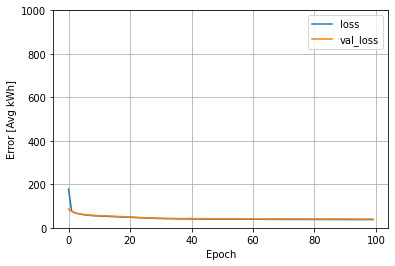

In [33]:
leaky_relu_dnn_model = build_and_compile_model(normalizer, "leaky_relu")
leaky_relu_dnn_model.summary()

history = leaky_relu_dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

In [44]:
best_model = get_best_model(leaky_relu_dnn_model, best_model)
res_val = perform_eval(leaky_relu_dnn_model, "DNN (Leaky ReLU)")
for key in res_val:
    print(f"{key}: {res_val[key]}")

filename = 'DNN (Leaky ReLU)'
save_location = os.path.join(".","trained_models", filename)
leaky_relu_dnn_model.save(save_location)

379/379 [==============================] - 1s 1ms/step
MSE (Train): 9995.327630083093
MSE (Test): 10112.913536930662
RMSE (Train): 99.97663542089768
RMSE (Test): 100.56298293572372
R2 (Train): 0.9460083862300531
R2 (Test): 0.9440803784754848
Adj R2 (Train): 0.9456494292698939
Adj R2 (Test): 0.9437086033801668


INFO:tensorflow:Assets written to: .\trained_models\DNN (Leaky ReLU)\assets


INFO:tensorflow:Assets written to: .\trained_models\DNN (Leaky ReLU)\assets


## Performance

In [45]:
all_df = compare_results("all")
all_df

,Models,MSE (Train),MSE (Test),RMSE (Train),RMSE (Test),R2 (Train),R2 (Test),Adj R2 (Train),Adj R2 (Test)
3,DNN (eLU),5316.102072,5795.132745,72.911605,76.125769,0.971284,0.967956,0.971093,0.967743
4,DNN (ReLU),5398.465904,5882.636159,73.474253,76.698345,0.970839,0.967472,0.970645,0.967256
2,DNN (Swish),5902.273171,6225.599025,76.826253,78.902465,0.968118,0.965575,0.967906,0.965347
5,DNN (GeLU),5703.629675,6239.575790,75.522379,78.990986,0.969191,0.965498,0.968986,0.965269
6,DNN (SeLU),6099.625969,6631.036601,78.100102,81.431177,0.967052,0.963334,0.966833,0.963090
7,DNN (Leaky ReLU),9995.327630,10112.913537,99.976635,100.562983,0.946008,0.944080,0.945649,0.943709
0,DNN (Sigmoid),22748.244634,24694.764459,150.825212,157.145679,0.877121,0.863450,0.876304,0.862542
1,DNN (Tanh),31163.247589,33717.201326,176.531152,183.622442,0.831666,0.813560,0.830547,0.812320
